# Step 4 (Optional): Generate more EEG Data using Generative Adversarial Networks (GANs)

If you want more EEG data or to augment your existing dataset, you can use GANs to generate synthetic EEG signals. Below is a simple example of how to implement a GAN for EEG data generation using Pytorch/TensorFlow, etc.

This notebook only provides a very simple structure for GANs. You may need to customize the architecture and training process based on your specific EEG data and requirements.

In [5]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.signal as sg
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# consistent random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [6]:
class GANTrainer:
    """A simple GAN for EEG data generation"""
    
    def __init__(self, data, name="gan", gan_type="wgan"):
        self.data = torch.FloatTensor(data)
        self.name = name
        self.gan_type = gan_type
        self.device = device
        
        n_samples, n_channels, n_timepoints = data.shape
        
        # generator: noise -> EEG
        self.G = nn.Sequential(
            nn.Linear(100, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, n_channels * n_timepoints),
            nn.Tanh()
        ).to(device)
        
        # discriminator: EEG -> real/fake
        self.D = nn.Sequential(
            nn.Linear(n_channels * n_timepoints, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        ).to(device)
        
        self.n_channels = n_channels
        self.n_timepoints = n_timepoints
    
    def train(self, epochs=50, batch_size=32):
        """Train the GAN"""
        G_opt = optim.Adam(self.G.parameters(), lr=0.0002)
        D_opt = optim.Adam(self.D.parameters(), lr=0.0002)
        
        dataset = torch.utils.data.TensorDataset(self.data)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            for real_batch in loader:
                real = real_batch[0].to(device).view(len(real_batch[0]), -1)
                B = real.size(0)
                
                D_opt.zero_grad()
                noise = torch.randn(B, 100, device=device)
                fake = self.G(noise).detach()
                
                if self.gan_type == "wgan":
                    # WGAN: maximize D(real) - D(fake)
                    D_loss = -(self.D(real).mean() - self.D(fake).mean())
                else:
                    # Vanilla GAN: BCE loss
                    D_real = torch.sigmoid(self.D(real))
                    D_fake = torch.sigmoid(self.D(fake))
                    D_loss = -torch.log(D_real + 1e-8).mean() - torch.log(1 - D_fake + 1e-8).mean()
                
                D_loss.backward()
                D_opt.step()
                
                # WGAN: clip weights
                if self.gan_type == "wgan":
                    for p in self.D.parameters():
                        p.data.clamp_(-0.01, 0.01)
                
                # Train Generator
                G_opt.zero_grad()
                noise = torch.randn(B, 100, device=device)
                fake = self.G(noise)
                
                if self.gan_type == "wgan":
                    G_loss = -self.D(fake).mean()
                else:
                    D_fake = torch.sigmoid(self.D(fake))
                    G_loss = -torch.log(D_fake + 1e-8).mean()
                
                G_loss.backward()
                G_opt.step()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} | D_loss: {D_loss.item():.3f} | G_loss: {G_loss.item():.3f}")
    
    def generate(self, n_samples=100):
        """Generate synthetic EEG"""
        self.G.eval()
        with torch.no_grad():
            noise = torch.randn(n_samples, 100, device=device)
            fake = self.G(noise).cpu().numpy()
            fake = fake.reshape(n_samples, self.n_channels, self.n_timepoints)
        return fake
    
    def compute_mmd(self, real, fake):
        """Compute Maximum Mean Discrepancy (MMD) - similarity metric"""
        real_flat = torch.FloatTensor(real.reshape(len(real), -1))
        fake_flat = torch.FloatTensor(fake.reshape(len(fake), -1))
        
        def rbf_kernel(x, y, sigma=1.0):
            x_size = x.size(0)
            y_size = y.size(0)
            
            # Compute pairwise distances
            x_tile = x.unsqueeze(1).expand(x_size, y_size, -1)
            y_tile = y.unsqueeze(0).expand(x_size, y_size, -1)
            
            dist = torch.sum((x_tile - y_tile) ** 2, dim=2)
            return torch.exp(-dist / (2 * sigma ** 2))
        
        # Use median heuristic for sigma
        with torch.no_grad():
            dist = torch.cdist(real_flat[:100], real_flat[:100])
            sigma = torch.median(dist[dist > 0]).item()
            sigma = max(sigma, 1e-6)
        
        # Compute kernels
        K_xx = rbf_kernel(real_flat, real_flat, sigma)
        K_yy = rbf_kernel(fake_flat, fake_flat, sigma)
        K_xy = rbf_kernel(real_flat, fake_flat, sigma)
        
        # MMD^2 = E[k(x,x)] + E[k(y,y)] - 2E[k(x,y)]
        n = len(real_flat)
        m = len(fake_flat)
        
        mmd_sq = K_xx.sum() / (n * (n - 1)) + K_yy.sum() / (m * (m - 1)) - 2 * K_xy.sum() / (n * m)
        mmd = torch.sqrt(torch.clamp(mmd_sq, min=0)).item()
        
        return mmd
    
    def evaluate(self, synthetic):
        """Evaluate quality using statistics and MMD (generated by copilot)"""
        real_np = self.data.cpu().numpy()
        
        mean_err = abs(real_np.mean() - synthetic.mean())
        std_err = abs(real_np.std() - synthetic.std())
        mmd = self.compute_mmd(real_np[:min(500, len(real_np))], synthetic[:min(500, len(synthetic))])
        
        # Quality scores
        stat_score = max(0, 100 - 1000 * mean_err - 100 * std_err)
        mmd_score = max(0, 100 * np.exp(-5 * mmd))
        overall = (stat_score + mmd_score) / 2
        
        quality = ("Excellent ⭐⭐⭐⭐⭐" if overall >= 80 else
                  "Good ⭐⭐⭐⭐" if overall >= 60 else
                  "Fair ⭐⭐⭐" if overall >= 40 else "Needs Work ⭐⭐")
        
        return {
            "mean_error": mean_err,
            "std_error": std_err,
            "mmd": mmd,
            "stat_score": stat_score,
            "mmd_score": mmd_score,
            "overall_score": overall,
            "quality": quality
        }
    
    def plot(self, synthetic):
        """Comprehensive visualization (generated by copilot)"""
        real_np = self.data.cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        
        # Row 1: Time domain comparison
        axes[0, 0].plot(real_np[0, 0], 'b-', lw=1.5, label='Real', alpha=0.8)
        axes[0, 0].plot(synthetic[0, 0], 'r--', lw=1.5, label='Generated', alpha=0.8)
        axes[0, 0].set_title('Channel 0: Time Domain', fontweight='bold')
        axes[0, 0].set_xlabel('Time (samples)')
        axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Multi-channel view
        for i in range(min(3, self.n_channels)):
            offset = i * 2 * real_np[0, i].std()
            axes[0, 1].plot(real_np[0, i] + offset, lw=0.8, alpha=0.7, label=f'Real Ch{i}')
            axes[0, 1].plot(synthetic[0, i] + offset, lw=0.8, alpha=0.7, ls='--', label=f'Gen Ch{i}')
        axes[0, 1].set_title('Multi-Channel View', fontweight='bold')
        axes[0, 1].set_xlabel('Time (samples)')
        axes[0, 1].legend(fontsize=8)
        axes[0, 1].grid(alpha=0.3)
        
        # PSD comparison
        from scipy import signal as sp_signal
        f_real, psd_real = sp_signal.welch(real_np[0, 0], fs=250, nperseg=128)
        f_gen, psd_gen = sp_signal.welch(synthetic[0, 0], fs=250, nperseg=128)
        axes[0, 2].semilogy(f_real, psd_real * 1e12, 'b-', lw=2, label='Real')
        axes[0, 2].semilogy(f_gen, psd_gen * 1e12, 'r--', lw=2, label='Generated')
        axes[0, 2].set_xlim(0, 50)
        axes[0, 2].set_title('PSD Comparison', fontweight='bold')
        axes[0, 2].set_xlabel('Frequency (Hz)')
        axes[0, 2].set_ylabel('PSD (µV²/Hz)')
        axes[0, 2].legend()
        axes[0, 2].grid(alpha=0.3)
        
        # Row 2: Statistical comparisons
        axes[1, 0].hist(real_np.flatten(), bins=50, alpha=0.5, density=True, color='b', label='Real')
        axes[1, 0].hist(synthetic.flatten(), bins=50, alpha=0.5, density=True, color='r', label='Generated')
        axes[1, 0].set_title('Amplitude Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Amplitude')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].legend()
        
        # Per-channel variance
        real_std = real_np.std(axis=2).mean(axis=0)
        gen_std = synthetic.std(axis=2).mean(axis=0)
        x = np.arange(min(10, len(real_std)))
        axes[1, 1].bar(x - 0.2, real_std[:len(x)], 0.4, label='Real', alpha=0.7)
        axes[1, 1].bar(x + 0.2, gen_std[:len(x)], 0.4, label='Generated', alpha=0.7)
        axes[1, 1].set_title('Channel Variance', fontweight='bold')
        axes[1, 1].set_xlabel('Channel')
        axes[1, 1].set_ylabel('Std Dev')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
        
        # Quality scores
        eval_results = self.evaluate(synthetic)
        scores = ['Stat\nScore', 'MMD\nScore', 'Overall']
        values = [eval_results['stat_score'], eval_results['mmd_score'], eval_results['overall_score']]
        colors = ['green' if v >= 60 else 'orange' if v >= 40 else 'red' for v in values]
        
        axes[1, 2].bar(scores, values, color=colors, alpha=0.7)
        axes[1, 2].set_ylim(0, 100)
        axes[1, 2].set_title(f"Quality: {eval_results['quality']}", fontweight='bold')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].grid(alpha=0.3, axis='y')
        
        for i, v in enumerate(values):
            axes[1, 2].text(i, v + 3, f'{v:.1f}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"Quality Metrics:")
        print(f"  Mean error: {eval_results['mean_error']:.6f}")
        print(f"  Std error:  {eval_results['std_error']:.6f}")
        print(f"  MMD:        {eval_results['mmd']:.6f}")
        print(f"  Overall:    {eval_results['overall_score']:.1f}/100 - {eval_results['quality']}")

In [7]:
# load EEG data

# Load individual segment files
individual_dir_closed = os.path.join('..', '..', 'gan_data', 'eyes_closed_individual')
individual_dir_open = os.path.join('..', '..', 'gan_data', 'eyes_open_individual')

closed_files = sorted(glob.glob(os.path.join(individual_dir_closed, '*.npy')))
open_files = sorted(glob.glob(os.path.join(individual_dir_open, '*.npy')))

print(f"Found {len(closed_files)} eyes closed segments")
print(f"Found {len(open_files)} eyes open segments")

segments_closed_full = np.array([np.load(f) for f in closed_files])
segments_open_full = np.array([np.load(f) for f in open_files])

print(f"Original shapes:")
print(f"  Eyes closed: {segments_closed_full.shape}")
print(f"  Eyes open: {segments_open_full.shape}")

segments_closed = segments_closed_full
segments_open = segments_open_full

print(f"Using: {segments_closed.shape}")

Found 444 eyes closed segments
Found 519 eyes open segments
Original shapes:
  Eyes closed: (444, 16, 500)
  Eyes open: (519, 16, 500)
Using: (444, 16, 500)
Original shapes:
  Eyes closed: (444, 16, 500)
  Eyes open: (519, 16, 500)
Using: (444, 16, 500)


Epoch 10/50 | D_loss: -36.090 | G_loss: 6.099
Epoch 20/50 | D_loss: -43.299 | G_loss: 52.000
Epoch 20/50 | D_loss: -43.299 | G_loss: 52.000
Epoch 30/50 | D_loss: -7.693 | G_loss: -2.727
Epoch 30/50 | D_loss: -7.693 | G_loss: -2.727
Epoch 40/50 | D_loss: -11.443 | G_loss: 11.359
Epoch 40/50 | D_loss: -11.443 | G_loss: 11.359
Epoch 50/50 | D_loss: -22.016 | G_loss: 35.763
Epoch 50/50 | D_loss: -22.016 | G_loss: 35.763


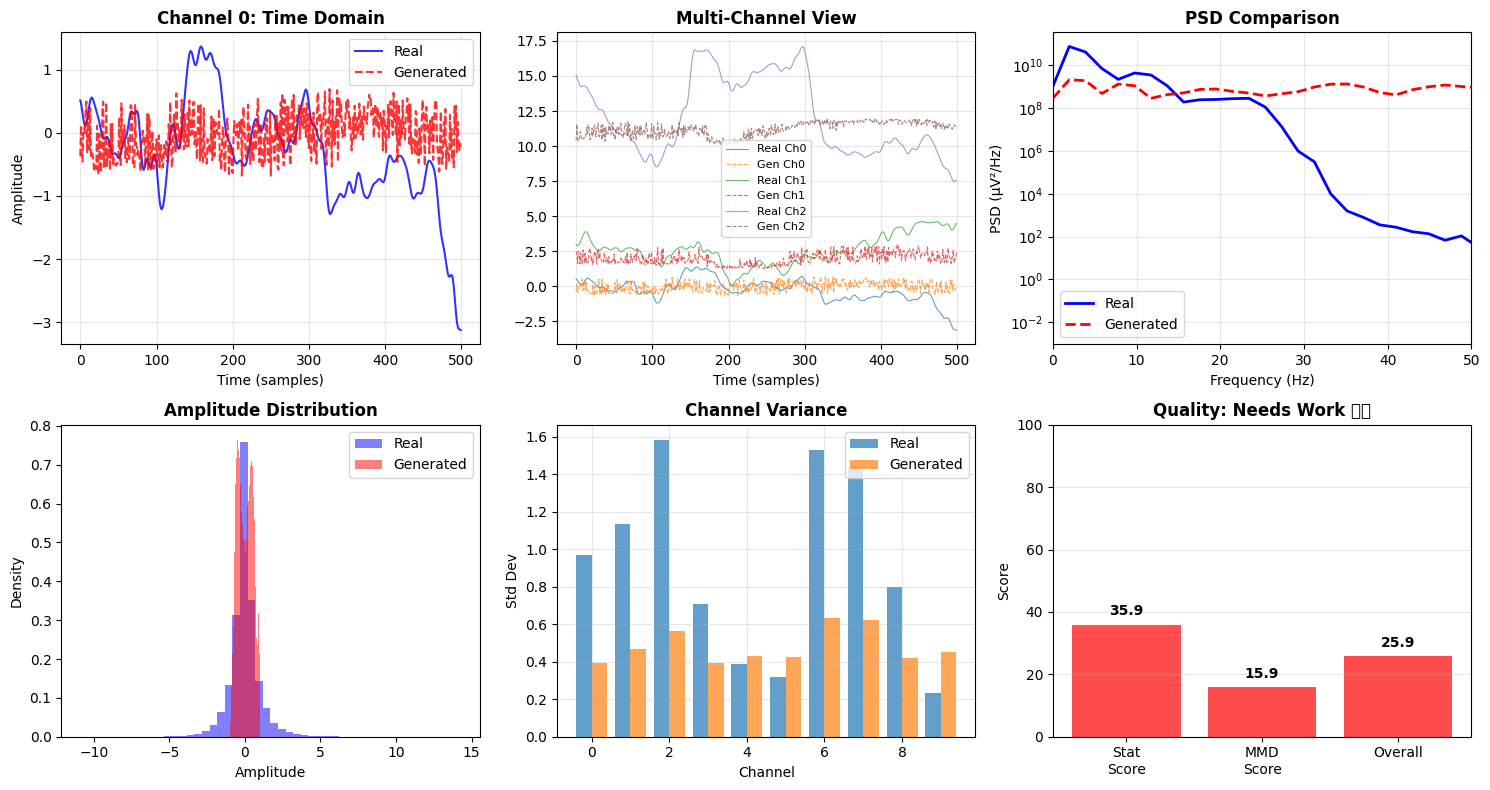

Quality Metrics:
  Mean error: 0.013154
  Std error:  0.509623
  MMD:        0.367312
  Overall:    25.9/100 - Needs Work ⭐⭐

✓ Generated: (100, 16, 500)
✓ Quality: 25.9/100 - Needs Work ⭐⭐


In [ ]:
# Train on EYES OPEN data
trainer_open = GANTrainer(segments_open, name='eyes_open', gan_type='wgan')
trainer_open.train(epochs=50)
synthetic_open = trainer_open.generate(100)

# Evaluate and visualize
eval_open = trainer_open.evaluate(synthetic_open)
trainer_open.plot(synthetic_open)

print(f"Generated: {synthetic_open.shape}")
print(f"Quality: {eval_open['overall_score']:.1f}/100 - {eval_open['quality']}")
# of course this is just a simple example and can be improved in many ways!

Epoch 10/50 | D_loss: -79.518 | G_loss: 55.308
Epoch 20/50 | D_loss: -0.237 | G_loss: -0.190
Epoch 20/50 | D_loss: -0.237 | G_loss: -0.190
Epoch 30/50 | D_loss: -11.162 | G_loss: -8.300
Epoch 30/50 | D_loss: -11.162 | G_loss: -8.300
Epoch 40/50 | D_loss: -20.166 | G_loss: 77.159
Epoch 40/50 | D_loss: -20.166 | G_loss: 77.159
Epoch 50/50 | D_loss: 17.181 | G_loss: -26.964
Epoch 50/50 | D_loss: 17.181 | G_loss: -26.964


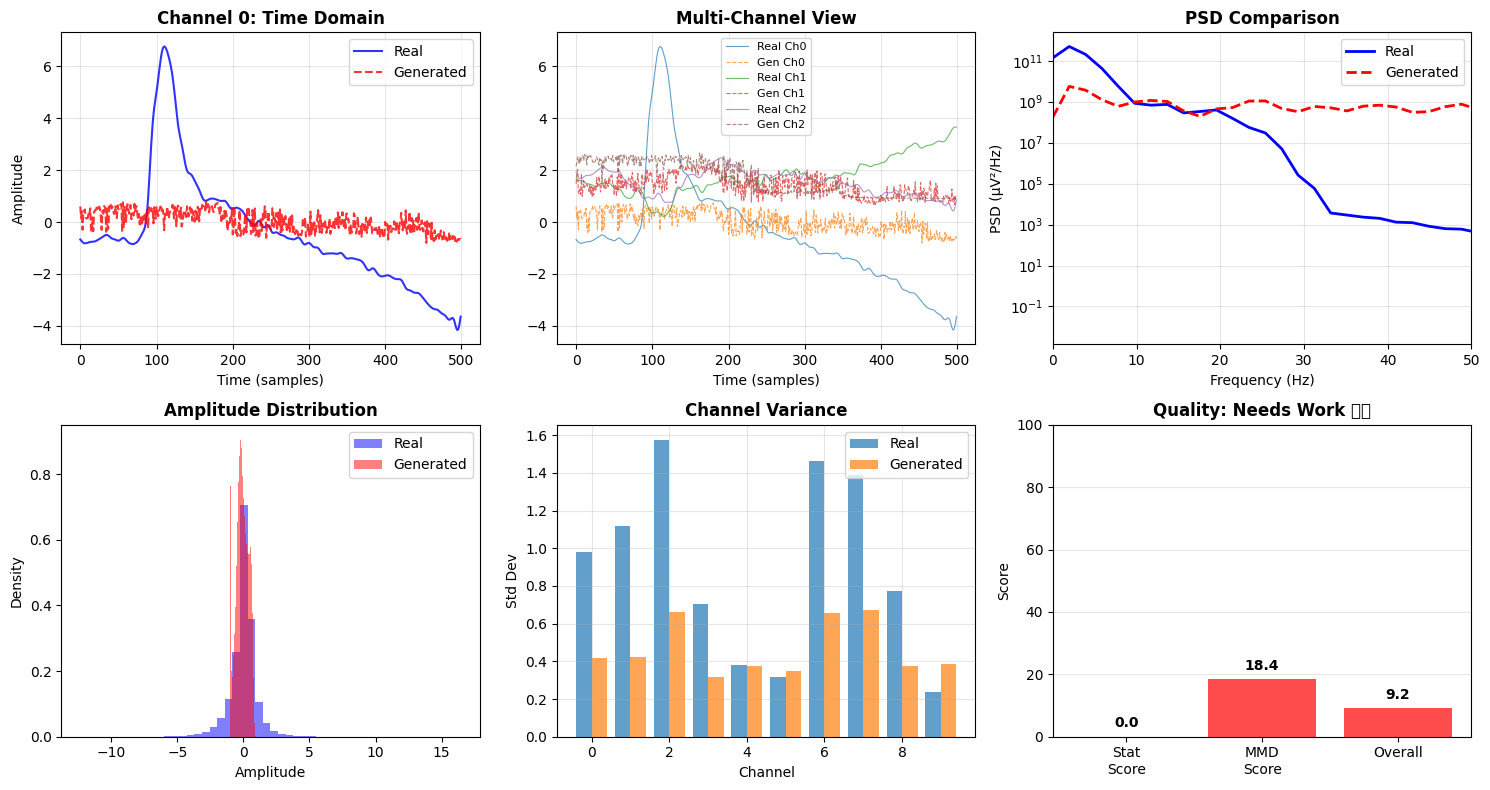

Quality Metrics:
  Mean error: 0.073598
  Std error:  0.553873
  MMD:        0.338969
  Overall:    9.2/100 - Needs Work ⭐⭐
Generated: (100, 16, 500)
Quality: 9.2/100 - Needs Work ⭐⭐


In [ ]:
# Train on EYES CLOSED data
trainer_closed = GANTrainer(segments_closed, name='eyes_closed', gan_type='wgan')
trainer_closed.train(epochs=50)
synthetic_closed = trainer_closed.generate(100)

# Evaluate and visualize
eval_closed = trainer_closed.evaluate(synthetic_closed)
trainer_closed.plot(synthetic_closed)

print(f"Generated: {synthetic_closed.shape}")
print(f"Quality: {eval_closed['overall_score']:.1f}/100 - {eval_closed['quality']}")
# of course this is just a simple example and can be improved in many ways!

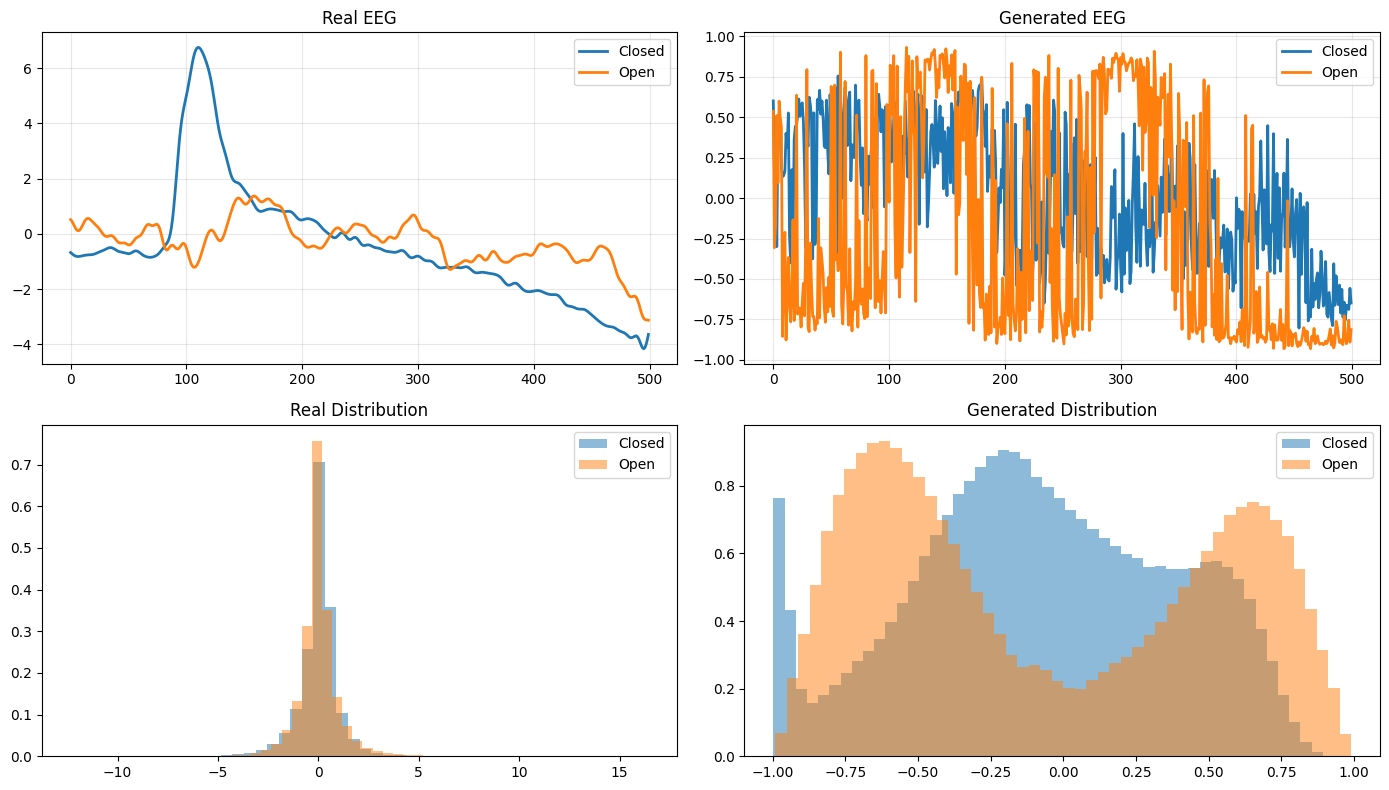


FINAL SUMMARY
Eyes Closed: 9.2/100 - Needs Work ⭐⭐
Eyes Open:   6.7/100 - Needs Work ⭐⭐
Average:     7.9/100


In [ ]:
# final comparison (in this case it has much more room for improvement...)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(segments_closed[0, 0], label='Closed', lw=2)
axes[0, 0].plot(segments_open[0, 0], label='Open', lw=2)
axes[0, 0].set_title('Real EEG'); axes[0, 0].legend(); axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(synthetic_closed[0, 0], label='Closed', lw=2)
axes[0, 1].plot(synthetic_open[0, 0], label='Open', lw=2)
axes[0, 1].set_title('Generated EEG'); axes[0, 1].legend(); axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(segments_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 0].hist(segments_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 0].set_title('Real Distribution'); axes[1, 0].legend()

axes[1, 1].hist(synthetic_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 1].hist(synthetic_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 1].set_title('Generated Distribution'); axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/final_comparison.png', dpi=150)
plt.show()

print(f"\n{'='*70}\nFINAL SUMMARY\n{'='*70}")
print(f"Eyes Closed: {eval_closed['overall_score']:.1f}/100 - {eval_closed['quality']}")
print(f"Eyes Open:   {eval_open['overall_score']:.1f}/100 - {eval_open['quality']}")
print(f"Average:     {(eval_closed['overall_score'] + eval_open['overall_score'])/2:.1f}/100")
print(f"{'='*70}")